## Imports/Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 26.3 MB/s eta 0:00:00


In [ ]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
import os
import re
import seaborn as sns
from tqdm import tqdm
import pickle
import numpy as np
import copy

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
from torchmetrics import Accuracy

# model assessment
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)

Device being used: cuda


## Word Embeddings

In [ ]:
class Vocabulary:
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vocab = w2v_model.index_to_key
        self.size = len(self.vocab)
        self.embed = w2v_model.vector_size
        mean_vector = w2v_model.get_mean_vector(self.vocab)
        self.w2v_model.add_vector('<pad>', np.zeros((self.embed)))
        self.w2v_model.add_vector('<unk>', mean_vector)

    def get_word_to_idx(self, word):
        if word not in self.vocab:
            word = '<unk>'
        return self.w2v_model.key_to_index[word]

    def get_embedding(self, word):
        if word not in self.vocab:
            word = '<unk>'
        return self.w2v_model[word]

In [ ]:
vocab = Vocabulary(model)

/usr/local/lib/python3.9/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


## DataLoader

In [ ]:
class AmazonFoodReview(Dataset):

    def __init__(self, path, dataset_type='train', feat='w2v'):
        self.X = np.load(f'{path}/X_{dataset_type}_{feat}_large', allow_pickle=True)
        self.y = np.load(f'{path}/y_{dataset_type}_large.npy', allow_pickle=True)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        return (X_sample, y_sample)

In [ ]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'

train_dataset = AmazonFoodReview(path=path, dataset_type='train', feat='w2v')
test_dataset = AmazonFoodReview(path=path, dataset_type='test', feat='w2v')

## Defining LSTM Structure

In [ ]:
# lstm
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, bidirectional=False):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim1, batch_first=True, bidirectional=bidirectional)
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.bifc = nn.Linear(2*hidden_dim1, output_dim)
        self.bidirectional = bidirectional
        
    def forward(self, embeddings):
        out, (h_n, c_n) = self.lstm(embeddings)
        lstm_output = h_n[0]
        if self.bidirectional:
            opp_output = h_n[-1]
            lstm_output = torch.stack([lstm_output, opp_output], axis=0)
            logits = self.bifc(lstm_output).squeeze(1)
        else:
            linear1_out = self.relu(self.fc1(lstm_output))
            logits = self.fc2(linear1_out).squeeze(1)
        return logits

In [ ]:
def evaluate(data_loader, model, criterion, metric):
    model.eval()

    total_loss = 0
    total_acc = 0
    for sample in tqdm(data_loader):
        X_batch, y_batch = sample

        X_batch = X_batch.type(torch.float32).to(device)
        y_batch = y_batch.type(torch.float32).to(device)

        logits = model(X_batch)

        loss = criterion(logits, y_batch)
        total_loss += loss.item()

        batch_accuracy = metric(logits, y_batch)
        total_acc += batch_accuracy

    total_loss /= len(data_loader)
    total_acc /= len(data_loader)
    return total_loss, total_acc.item()

In [ ]:
def training_loop(train_loader, test_loader, input_dim, hidden_dim1, hidden_dim2, output_dim, lr=1e-3, epochs=2, device='cuda'):

    model = LSTM(input_dim, hidden_dim1, hidden_dim2, output_dim)
    model.to(device)

    epoch_loss_all = []
    epoch_acc_all = []
    train_loss_all = []
    train_acc_all = []
    test_loss_all = []
    test_acc_all = []

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracy = Accuracy(task="binary", threshold=0.5).to(device)

    best_test_acc = 0

    for i, epoch in enumerate(range(epochs)):

        epoch_loss = 0
        epoch_accuracy = 0
        print(f"Epoch {i} starting ...\n")
        model.train()

        for sample in tqdm(train_loader):

            optimizer.zero_grad()

            X_batch, y_batch = sample
            X_batch = X_batch.type(torch.float32).to(device)
            y_batch = y_batch.type(torch.float32).to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            batch_accuracy = accuracy(logits, y_batch)
            epoch_accuracy += batch_accuracy
        
        epoch_accuracy /= len(train_loader)
        epoch_loss /= len(train_loader)
        print(f"\nEpoch Loss: {epoch_loss}")
        print(f"Epoch Accuracy: {epoch_accuracy}")
        epoch_loss_all.append(epoch_loss)
        epoch_acc_all.append(epoch_accuracy.item())

        print("Evaluating created model...")
        train_loss, train_acc = evaluate(train_loader, model, criterion, accuracy)
        test_loss, test_acc = evaluate(test_loader, model, criterion, accuracy)
        print(f"\nTrain Loss: {train_loss}")
        print(f"Train Accuracy: {train_acc}")
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_acc}")
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        test_loss_all.append(test_loss)
        test_acc_all.append(test_acc)
        print("-----------------------------------\n")

        if best_test_acc < test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), f'{path}/final_model_lstm_word2vec.pt')
    return epoch_loss_all, epoch_acc_all, train_loss_all, train_acc_all, test_loss_all, test_acc_all

In [ ]:
# hyperparameters
input_dim = 300
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 1
batch_size = 64
epochs = 50
learning_rate = 1e-3

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
epoch_loss_all, epoch_acc_all, train_loss_all, train_acc_all, test_loss_all, test_acc_all = training_loop(
    train_loader, 
    test_loader,
    input_dim, 
    hidden_dim1, 
    hidden_dim2, 
    output_dim, 
    epochs=epochs, 
    lr = learning_rate, 
    device=device)

Epoch 0 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.35it/s]



Epoch Loss: 0.6918625664710999
Epoch Accuracy: 0.5235000252723694
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.00it/s]



Train Loss: 0.6907071862220764
Train Accuracy: 0.5443750023841858
Test Loss: 0.6902791019529104
Test Accuracy: 0.5537109375
-----------------------------------

Epoch 1 starting ...



100%|██████████| 125/125 [00:02<00:00, 60.64it/s]



Epoch Loss: 0.6869376029968262
Epoch Accuracy: 0.5487500429153442
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 33.37it/s]



Train Loss: 0.6968013849258423
Train Accuracy: 0.5875000357627869
Test Loss: 0.6981834638863802
Test Accuracy: 0.583984375
-----------------------------------

Epoch 2 starting ...



100%|██████████| 125/125 [00:02<00:00, 60.32it/s]



Epoch Loss: 0.6902674403190613
Epoch Accuracy: 0.5358750224113464
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.39it/s]



Train Loss: 0.6888760027885437
Train Accuracy: 0.5413750410079956
Test Loss: 0.6879509929567575
Test Accuracy: 0.5498046875
-----------------------------------

Epoch 3 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.28it/s]



Epoch Loss: 0.6783839416503906
Epoch Accuracy: 0.5721250176429749
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 52.90it/s]



Train Loss: 0.6897979788780212
Train Accuracy: 0.5352500081062317
Test Loss: 0.6904091294854879
Test Accuracy: 0.53857421875
-----------------------------------

Epoch 4 starting ...



100%|██████████| 125/125 [00:01<00:00, 65.05it/s]



Epoch Loss: 0.6845419387817383
Epoch Accuracy: 0.5548750162124634
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 33.11it/s]



Train Loss: 0.6929877562522888
Train Accuracy: 0.5045000314712524
Test Loss: 0.6932983566075563
Test Accuracy: 0.50341796875
-----------------------------------

Epoch 5 starting ...



100%|██████████| 125/125 [00:02<00:00, 60.82it/s]



Epoch Loss: 0.6926682085990906
Epoch Accuracy: 0.5051250457763672
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.28it/s]



Train Loss: 0.6922279725074768
Train Accuracy: 0.5062500238418579
Test Loss: 0.6930001005530357
Test Accuracy: 0.5
-----------------------------------

Epoch 6 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.66it/s]



Epoch Loss: 0.6908747000694275
Epoch Accuracy: 0.5100000500679016
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.37it/s]



Train Loss: 0.6888818502426147
Train Accuracy: 0.5131250023841858
Test Loss: 0.69102075509727
Test Accuracy: 0.50390625
-----------------------------------

Epoch 7 starting ...



100%|██████████| 125/125 [00:02<00:00, 58.63it/s]



Epoch Loss: 0.687558837890625
Epoch Accuracy: 0.5141250491142273
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 36.24it/s]



Train Loss: 0.6843001537322998
Train Accuracy: 0.5192500352859497
Test Loss: 0.689161816611886
Test Accuracy: 0.50830078125
-----------------------------------

Epoch 8 starting ...



100%|██████████| 125/125 [00:02<00:00, 61.00it/s]



Epoch Loss: 0.6853303065299988
Epoch Accuracy: 0.5382500290870667
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 52.92it/s]



Train Loss: 0.6739552659988404
Train Accuracy: 0.6411250233650208
Test Loss: 0.6726862397044897
Test Accuracy: 0.64306640625
-----------------------------------

Epoch 9 starting ...



100%|██████████| 125/125 [00:01<00:00, 63.54it/s]



Epoch Loss: 0.678383165359497
Epoch Accuracy: 0.5883750319480896
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 52.39it/s]



Train Loss: 0.6604036521911621
Train Accuracy: 0.612250030040741
Test Loss: 0.6632840186357498
Test Accuracy: 0.60888671875
-----------------------------------

Epoch 10 starting ...



100%|██████████| 125/125 [00:02<00:00, 58.58it/s]



Epoch Loss: 0.6759865603446961
Epoch Accuracy: 0.6043750047683716
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 34.62it/s]



Train Loss: 0.6950463490486145
Train Accuracy: 0.5
Test Loss: 0.6950550433248281
Test Accuracy: 0.49853515625
-----------------------------------

Epoch 11 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.97it/s]



Epoch Loss: 0.6929258561134338
Epoch Accuracy: 0.5071250200271606
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 52.84it/s]



Train Loss: 0.693012556552887
Train Accuracy: 0.5
Test Loss: 0.6925422959029675
Test Accuracy: 0.50146484375
-----------------------------------

Epoch 12 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.61it/s]



Epoch Loss: 0.6919922456741333
Epoch Accuracy: 0.5191250443458557
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.51it/s]



Train Loss: 0.690724377155304
Train Accuracy: 0.534125030040741
Test Loss: 0.6897194124758244
Test Accuracy: 0.54931640625
-----------------------------------

Epoch 13 starting ...



100%|██████████| 125/125 [00:02<00:00, 59.31it/s]



Epoch Loss: 0.6904204053878784
Epoch Accuracy: 0.5316250324249268
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 33.88it/s]



Train Loss: 0.688782479763031
Train Accuracy: 0.5377500057220459
Test Loss: 0.6863243747502565
Test Accuracy: 0.55517578125
-----------------------------------

Epoch 14 starting ...



100%|██████████| 125/125 [00:01<00:00, 63.87it/s]



Epoch Loss: 0.6875838279724121
Epoch Accuracy: 0.5455000400543213
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.30it/s]



Train Loss: 0.6819142699241638
Train Accuracy: 0.5900000333786011
Test Loss: 0.6803563479334116
Test Accuracy: 0.5947265625
-----------------------------------

Epoch 15 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.21it/s]



Epoch Loss: 0.6929875206947327
Epoch Accuracy: 0.5055000185966492
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 52.95it/s]



Train Loss: 0.6867210502624512
Train Accuracy: 0.5471250414848328
Test Loss: 0.6880971379578114
Test Accuracy: 0.548828125
-----------------------------------

Epoch 16 starting ...



100%|██████████| 125/125 [00:02<00:00, 60.96it/s]



Epoch Loss: 0.6912120275497436
Epoch Accuracy: 0.5237500071525574
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 33.96it/s]



Train Loss: 0.6901993980407715
Train Accuracy: 0.5080000162124634
Test Loss: 0.6901494208723307
Test Accuracy: 0.50439453125
-----------------------------------

Epoch 17 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.49it/s]



Epoch Loss: 0.6879599757194519
Epoch Accuracy: 0.5433750152587891
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 54.96it/s]



Train Loss: 0.6885887784957886
Train Accuracy: 0.5426250100135803
Test Loss: 0.6866682264953852
Test Accuracy: 0.5546875
-----------------------------------

Epoch 18 starting ...



100%|██████████| 125/125 [00:01<00:00, 65.71it/s]



Epoch Loss: 0.6890597066879273
Epoch Accuracy: 0.5401250123977661
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.85it/s]



Train Loss: 0.6858208031654358
Train Accuracy: 0.5472500324249268
Test Loss: 0.6824310757219791
Test Accuracy: 0.5703125
-----------------------------------

Epoch 19 starting ...



100%|██████████| 125/125 [00:02<00:00, 61.21it/s]



Epoch Loss: 0.6841243748664856
Epoch Accuracy: 0.5506250262260437
Evaluating created model...


100%|██████████| 32/32 [00:01<00:00, 23.50it/s]



Train Loss: 0.6763284468650818
Train Accuracy: 0.5702500343322754
Test Loss: 0.6751229949295521
Test Accuracy: 0.57568359375
-----------------------------------

Epoch 20 starting ...



100%|██████████| 125/125 [00:04<00:00, 29.39it/s]



Epoch Loss: 0.6802301049232483
Epoch Accuracy: 0.5588750243186951
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.73it/s]



Train Loss: 0.6663779621124267
Train Accuracy: 0.5843750238418579
Test Loss: 0.6688469983637333
Test Accuracy: 0.58935546875
-----------------------------------

Epoch 21 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.02it/s]



Epoch Loss: 0.6718129024505616
Epoch Accuracy: 0.5763750076293945
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 34.60it/s]



Train Loss: 0.7016616778373719
Train Accuracy: 0.499500036239624
Test Loss: 0.7035996969789267
Test Accuracy: 0.49462890625
-----------------------------------

Epoch 22 starting ...



100%|██████████| 125/125 [00:02<00:00, 53.53it/s]



Epoch Loss: 0.6927880234718323
Epoch Accuracy: 0.5195000171661377
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.13it/s]



Train Loss: 0.6912680115699769
Train Accuracy: 0.5318750143051147
Test Loss: 0.6914031654596329
Test Accuracy: 0.53662109375
-----------------------------------

Epoch 23 starting ...



100%|██████████| 125/125 [00:01<00:00, 66.52it/s]



Epoch Loss: 0.6908851327896118
Epoch Accuracy: 0.5287500023841858
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.33it/s]



Train Loss: 0.6903109874725342
Train Accuracy: 0.534250020980835
Test Loss: 0.6896339301019907
Test Accuracy: 0.54248046875
-----------------------------------

Epoch 24 starting ...



100%|██████████| 125/125 [00:01<00:00, 65.00it/s]



Epoch Loss: 0.6899002313613891
Epoch Accuracy: 0.5285000205039978
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 32.62it/s]



Train Loss: 0.6889100399017334
Train Accuracy: 0.5320000052452087
Test Loss: 0.688396506011486
Test Accuracy: 0.5458984375
-----------------------------------

Epoch 25 starting ...



100%|██████████| 125/125 [00:02<00:00, 49.67it/s]



Epoch Loss: 0.6883915386199951
Epoch Accuracy: 0.5360000133514404
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.01it/s]



Train Loss: 0.687100522518158
Train Accuracy: 0.5360000133514404
Test Loss: 0.6874254047870636
Test Accuracy: 0.54052734375
-----------------------------------

Epoch 26 starting ...



100%|██████████| 125/125 [00:01<00:00, 62.97it/s]



Epoch Loss: 0.6869694399833679
Epoch Accuracy: 0.5386250019073486
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 52.36it/s]



Train Loss: 0.6848111748695374
Train Accuracy: 0.5386250019073486
Test Loss: 0.6850417293608189
Test Accuracy: 0.541015625
-----------------------------------

Epoch 27 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.48it/s]



Epoch Loss: 0.6831956391334534
Epoch Accuracy: 0.5481250286102295
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 34.86it/s]



Train Loss: 0.6801673474311829
Train Accuracy: 0.5543750524520874
Test Loss: 0.6832192409783602
Test Accuracy: 0.546875
-----------------------------------

Epoch 28 starting ...



100%|██████████| 125/125 [00:02<00:00, 54.52it/s]



Epoch Loss: 0.6721063437461853
Epoch Accuracy: 0.5711250305175781
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.49it/s]



Train Loss: 0.6475766448974609
Train Accuracy: 0.6802500486373901
Test Loss: 0.64993916451931
Test Accuracy: 0.68359375
-----------------------------------

Epoch 29 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.82it/s]



Epoch Loss: 0.6517779035568237
Epoch Accuracy: 0.6290000081062317
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 52.23it/s]



Train Loss: 0.6212351317405701
Train Accuracy: 0.6645000576972961
Test Loss: 0.6263701766729355
Test Accuracy: 0.65625
-----------------------------------

Epoch 30 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.03it/s]



Epoch Loss: 0.6673908433914184
Epoch Accuracy: 0.6007500290870667
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 32.97it/s]



Train Loss: 0.6243871536254882
Train Accuracy: 0.6668750047683716
Test Loss: 0.6304199229925871
Test Accuracy: 0.67138671875
-----------------------------------

Epoch 31 starting ...



100%|██████████| 125/125 [00:02<00:00, 54.32it/s]



Epoch Loss: 0.6596606495380402
Epoch Accuracy: 0.6295000314712524
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 55.57it/s]



Train Loss: 0.6851854681968689
Train Accuracy: 0.49275001883506775
Test Loss: 0.6882752422243357
Test Accuracy: 0.4794921875
-----------------------------------

Epoch 32 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.42it/s]



Epoch Loss: 0.6855155234336853
Epoch Accuracy: 0.5238749980926514
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 55.24it/s]



Train Loss: 0.6898731045722961
Train Accuracy: 0.5167500376701355
Test Loss: 0.6914320942014456
Test Accuracy: 0.51220703125
-----------------------------------

Epoch 33 starting ...



100%|██████████| 125/125 [00:01<00:00, 63.36it/s]



Epoch Loss: 0.6876774053573609
Epoch Accuracy: 0.5357500314712524
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 34.47it/s]



Train Loss: 0.6823456692695617
Train Accuracy: 0.5553750395774841
Test Loss: 0.6853656265884638
Test Accuracy: 0.55029296875
-----------------------------------

Epoch 34 starting ...



100%|██████████| 125/125 [00:02<00:00, 54.32it/s]



Epoch Loss: 0.6783273711204528
Epoch Accuracy: 0.559249997138977
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 53.92it/s]



Train Loss: 0.6868755130767822
Train Accuracy: 0.5322500467300415
Test Loss: 0.6882879547774792
Test Accuracy: 0.53955078125
-----------------------------------

Epoch 35 starting ...



100%|██████████| 125/125 [00:01<00:00, 63.66it/s]



Epoch Loss: 0.6782537431716918
Epoch Accuracy: 0.5557500123977661
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.62it/s]



Train Loss: 0.7455455198287964
Train Accuracy: 0.5206249952316284
Test Loss: 0.744728434830904
Test Accuracy: 0.52490234375
-----------------------------------

Epoch 36 starting ...



100%|██████████| 125/125 [00:01<00:00, 64.78it/s]



Epoch Loss: 0.6896151847839356
Epoch Accuracy: 0.518375039100647
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 33.16it/s]



Train Loss: 0.6845718321800232
Train Accuracy: 0.5447500348091125
Test Loss: 0.6858681812882423
Test Accuracy: 0.5361328125
-----------------------------------

Epoch 37 starting ...



100%|██████████| 125/125 [00:02<00:00, 53.39it/s]



Epoch Loss: 0.6816111335754395
Epoch Accuracy: 0.5452499985694885
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 33.44it/s]



Train Loss: 0.6777003555297851
Train Accuracy: 0.5530000329017639
Test Loss: 0.6764721535146236
Test Accuracy: 0.56640625
-----------------------------------

Epoch 38 starting ...



100%|██████████| 125/125 [00:01<00:00, 63.80it/s]



Epoch Loss: 0.6630096759796142
Epoch Accuracy: 0.5746250152587891
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.22it/s]



Train Loss: 0.6274765849113464
Train Accuracy: 0.6300000548362732
Test Loss: 0.6330723911523819
Test Accuracy: 0.6240234375
-----------------------------------

Epoch 39 starting ...



100%|██████████| 125/125 [00:02<00:00, 45.41it/s]



Epoch Loss: 0.7183844804763794
Epoch Accuracy: 0.5067500472068787
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 52.93it/s]



Train Loss: 0.6928497347831726
Train Accuracy: 0.499875009059906
Test Loss: 0.693248363211751
Test Accuracy: 0.50146484375
-----------------------------------

Epoch 40 starting ...



100%|██████████| 125/125 [00:02<00:00, 54.36it/s]



Epoch Loss: 0.6927030205726623
Epoch Accuracy: 0.5097500085830688
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 33.92it/s]



Train Loss: 0.6921591715812683
Train Accuracy: 0.5293750166893005
Test Loss: 0.692228002473712
Test Accuracy: 0.51513671875
-----------------------------------

Epoch 41 starting ...



100%|██████████| 125/125 [00:02<00:00, 49.96it/s]



Epoch Loss: 0.6923261437416076
Epoch Accuracy: 0.515250027179718
Evaluating created model...


100%|██████████| 32/32 [00:01<00:00, 27.62it/s]



Train Loss: 0.6915518288612366
Train Accuracy: 0.5321249961853027
Test Loss: 0.6912959888577461
Test Accuracy: 0.5439453125
-----------------------------------

Epoch 42 starting ...



100%|██████████| 125/125 [00:03<00:00, 35.38it/s]



Epoch Loss: 0.6917732877731323
Epoch Accuracy: 0.5192500352859497
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.94it/s]



Train Loss: 0.6910639152526855
Train Accuracy: 0.5322500467300415
Test Loss: 0.690544368699193
Test Accuracy: 0.54345703125
-----------------------------------

Epoch 43 starting ...



100%|██████████| 125/125 [00:02<00:00, 60.75it/s]



Epoch Loss: 0.6912757363319397
Epoch Accuracy: 0.5242500305175781
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 49.88it/s]



Train Loss: 0.6910776724815368
Train Accuracy: 0.5331250429153442
Test Loss: 0.6908682268112898
Test Accuracy: 0.537109375
-----------------------------------

Epoch 44 starting ...



100%|██████████| 125/125 [00:02<00:00, 60.15it/s]



Epoch Loss: 0.6908779149055481
Epoch Accuracy: 0.530750036239624
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 48.67it/s]



Train Loss: 0.6900947556495667
Train Accuracy: 0.5315000414848328
Test Loss: 0.689712967723608
Test Accuracy: 0.541015625
-----------------------------------

Epoch 45 starting ...



100%|██████████| 125/125 [00:03<00:00, 39.07it/s]



Epoch Loss: 0.6905419883728028
Epoch Accuracy: 0.5288750529289246
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 49.94it/s]



Train Loss: 0.6901759209632874
Train Accuracy: 0.5332500338554382
Test Loss: 0.6897918451577425
Test Accuracy: 0.537109375
-----------------------------------

Epoch 46 starting ...



100%|██████████| 125/125 [00:01<00:00, 62.84it/s]



Epoch Loss: 0.6901556825637818
Epoch Accuracy: 0.5267500281333923
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 51.10it/s]



Train Loss: 0.6894989094734192
Train Accuracy: 0.53125
Test Loss: 0.6883771009743214
Test Accuracy: 0.544921875
-----------------------------------

Epoch 47 starting ...



100%|██████████| 125/125 [00:01<00:00, 62.73it/s]



Epoch Loss: 0.6898555188179016
Epoch Accuracy: 0.5328750014305115
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 40.03it/s]



Train Loss: 0.6888269324302674
Train Accuracy: 0.5320000052452087
Test Loss: 0.6879532039165497
Test Accuracy: 0.54638671875
-----------------------------------

Epoch 48 starting ...



100%|██████████| 125/125 [00:03<00:00, 39.79it/s]



Epoch Loss: 0.6890021276473999
Epoch Accuracy: 0.5325000286102295
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 50.46it/s]



Train Loss: 0.6882307653427124
Train Accuracy: 0.5315000414848328
Test Loss: 0.6881576143205166
Test Accuracy: 0.53857421875
-----------------------------------

Epoch 49 starting ...



100%|██████████| 125/125 [00:02<00:00, 62.12it/s]



Epoch Loss: 0.6884609379768372
Epoch Accuracy: 0.5347500443458557
Evaluating created model...


100%|██████████| 32/32 [00:00<00:00, 50.23it/s]


Train Loss: 0.6876258850097656
Train Accuracy: 0.534500002861023
Test Loss: 0.6879142634570599
Test Accuracy: 0.54150390625
-----------------------------------



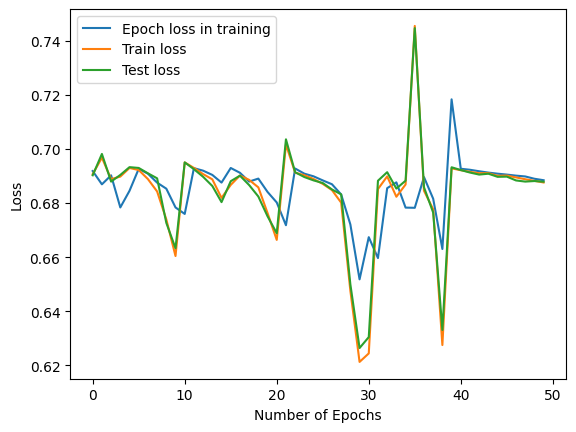

In [ ]:
epochs = [i for i in range(len(epoch_loss_all))]
plt.plot(epochs, epoch_loss_all, label='Epoch loss in training')
plt.plot(epochs, train_loss_all, label='Train loss')
plt.plot(epochs, test_loss_all, label='Test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

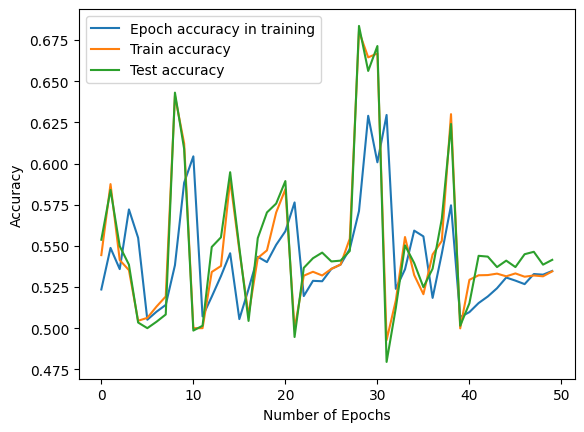

In [ ]:
epochs = [i for i in range(len(epoch_acc_all))]
plt.plot(epochs, epoch_acc_all, label='Epoch accuracy in training')
plt.plot(epochs, train_acc_all, label='Train accuracy')
plt.plot(epochs, test_acc_all, label='Test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
best_model = LSTM(input_dim, hidden_dim1, hidden_dim2, output_dim)
best_model.load_state_dict(torch.load(f'{path}/final_model_lstm_word2vec.pt'))
best_model.to(device)
criterion = nn.BCEWithLogitsLoss()
accuracy = Accuracy(task="binary", threshold=0.5).to(device)
print("Train loss, Train accuracy: ", evaluate(train_loader, best_model, criterion, accuracy))
print()
print("\nTest loss, Test accuracy: ", evaluate(test_loader, best_model, criterion, accuracy))

100%|██████████| 125/125 [00:01<00:00, 75.82it/s]


Train loss, Train accuracy:  (0.6475766410827637, 0.6802500486373901)



100%|██████████| 32/32 [00:00<00:00, 51.01it/s]


Test loss, Test accuracy:  (0.6499331425875425, 0.677734375)


In [ ]:
class MovieReview(Dataset):

    def __init__(self, path, dataset_type='train', feat='w2v'):
        self.X = np.load(f'{path}/X_{dataset_type}_{feat}_large', allow_pickle=True)
        self.y = np.load(f'{path}/y_{dataset_type}_large.npy', allow_pickle=True)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        return (X_sample, y_sample)